In [1]:
from torchvision import models, transforms
from PIL import Image
import torch
from models import *
import matplotlib.pyplot as plt 
import numpy as np
import torch.nn as nn
from captum.attr import visualization as viz
from dataloaders import presets
import os
import pickle
import pandas as pd
from utils.utils import create_folder, load_config
from dataloaders.presets import PresetTransform
from captum.attr import *

from skimage.segmentation import slic, mark_boundaries
from captum.metrics import infidelity, sensitivity_max
from tqdm import tqdm
from PIL import ImageFilter

c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Folds Results

In [2]:
device = 'cuda'
model = 'NCNN'

path_experiments = f'experiments\\{model}'

# Aux Functions

In [ ]:
def perturb_fn(inputs):
    noise = torch.tensor(np.random.normal(0, 0.1, inputs.shape)).float().to(inputs.device)
    return noise, torch.clip(inputs - noise, 0, 1)

def rgb_to_gray_and_scale(x):
    x = np.asarray(x)
    # Shape must be in (H, W, C)
    x_combined = np.sum(x, axis=2)

    sorted_vals = np.sort(np.abs(x_combined).flatten())
    cum_sums = np.cumsum(sorted_vals)
    threshold_id: int = np.where(cum_sums >= cum_sums[-1] * 0.01 * 98)[0][0]
    threshold = sorted_vals[threshold_id]

    attr_norm = x_combined / threshold
    
    return np.clip(attr_norm, -1, 1)

# --- Create superpixel feature mask for Captum ---
def make_feature_mask(img_tensor, n_segments=100):
    x = img_tensor.detach().cpu().squeeze(0)  # 3 x H x W
    x_np = x.numpy()
    x_np = (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-8)
    x_np = np.transpose(x_np, (1, 2, 0))  # H, W, 3

    seg = slic(x_np, n_segments=n_segments, compactness=10.0, sigma=0.0,
               start_label=0, channel_axis=2)

    seg_t = torch.from_numpy(seg).long().unsqueeze(0).unsqueeze(0)
    return seg_t, seg

# Run for each Explainer

In [13]:
import attr
from sklearn import base


all_data ={'img_path': [], 'fold': [], 'label': [], 
           'prediction': [], 'probability': [],
           'sensitivity': [], 'infidelity': [],
           'mask_path': []}


for exp in os.listdir(path_experiments):
    # Skip non-experiment folders/files.
    if any(ext in exp for ext in ['.pkl', 'masks', '.png', '.pdf']):
        continue

    # Load model and configuration.
    path_model = os.path.join(path_experiments, exp, 'Model', 'best_model.pt')
    path_yaml  = os.path.join(path_experiments, exp, 'Model', 'config.yaml')
    config     = load_config(path_yaml)
    test_path  = config['path_test']

    # Set up the model, transforms, and attribution objects based on experiment type.
    if "NCNN" in exp:
        model = NCNN().to(device)
        img_size = 120
        transform = PresetTransform("NCNN").transforms
    elif "VGGFace" in exp:
        model = VGGFace().to(device)
        img_size = 224
        transform = PresetTransform("VGGFace").transforms
    elif "ViT" in exp:
        model = ViT().to(device)
        img_size = 224
        transform = PresetTransform("ViT").transforms
    else:
        continue

    # Load the trained weights and set the model to evaluation mode.
    model.load_state_dict(torch.load(path_model))
    model.eval()

    # Get list of test images.
    image_files = [f for f in os.listdir(test_path) if f.endswith('.jpg')]

    for image_file in tqdm(image_files):
        full_img_path = os.path.join(test_path, image_file)

        img_rgb = Image.open(os.path.join(full_img_path)).convert("RGB")
        img_rgb = img_rgb.resize((img_size, img_size))
        
        img_name = image_file.split(".jpg")[0]
        # Extract label from the filename.
        label = 1 if image_file.split(".jpg")[0].split("_")[3] == 'pain' else 0

        if "VGGFace" in exp:
            img_input = Image.fromarray(np.array(img_rgb)[:, :, ::-1])
        else:
            img_input = img_rgb

        blurred_image = img_input.filter(ImageFilter.GaussianBlur(radius=5))

        transformed = transform(img_input)
        transformed_blurred = transform(blurred_image)

        input_tensor = transformed.unsqueeze(0).to(device)
        input_tensor_blurred = transformed_blurred.unsqueeze(0).to(device)

        XAI_name = "DeepL"  # Change as needed

        create_folder(os.path.join("RGU", XAI_name))

        ## Integrated Gradients
        #attribution_method = IntegratedGradients(model)
        #kwargs = {}
        #attributions = attribution_method.attribute(input_tensor, **kwargs)
        
        # ------------------------------------------------------------ #

        ## Saliency
        #attribution_method = Saliency(model)
        #kwargs = {}
        #attributions = attribution_method.attribute(input_tensor, **kwargs)
        
        # ------------------------------------------------------------ #

        ## DeepLift
        #attribution_method = DeepLift(model)
        #kwargs = {'baselines': input_tensor_blurred}
        #input_tensor = input_tensor.contiguous()
        #attributions = attribution_method.attribute(input_tensor, **kwargs)
        
        # ------------------------------------------------------------ #

        ## Occlusion
        #attribution_method = Occlusion(model)
        #kwargs = {'sliding_window_shapes':(3,5,5)}
        #attributions = attribution_method.attribute(input_tensor, **kwargs)

        # ------------------------------------------------------------ #

        ## GradCAM
        #attribution_method = LayerGradCam(model, model.merge_branch[0])
        #kwargs = {}
        #attributions = attribution_method.attribute(input_tensor, **kwargs)
        #attributions = LayerAttribution.interpolate(attributions, (img_size, img_size), interpolate_mode="bilinear")
        #attributions = attributions.repeat(1, 3, 1, 1)
        
        # ------------------------------------------------------------ #

        ## Guided GradCAM
        #attribution_method = GuidedGradCam(model, model.merge_branch[0])
        #kwargs = {}
        #attributions = attribution_method.attribute(input_tensor, **kwargs)
        
        # ------------------------------------------------------------ #

        ## Deconvolution
        #attribution_method = Deconvolution(model)
        #kwargs = {}
        #attributions = attribution_method.attribute(input_tensor, **kwargs)
        
        # ------------------------------------------------------------ #

        ## GradientSHAP
        #attribution_method = GradientShap(model)
        #kwargs = {'baselines': torch.zeros_like(input_tensor).to(device), 'n_samples': 5, 'stdevs': 0.1}
        #attributions = attribution_method.attribute(input_tensor, **kwargs)
        
        # ------------------------------------------------------------ #

        ## DeepLiftSHAP
        attribution_method = DeepLiftShap(model)
        kwargs = {'baselines': input_tensor_blurred.repeat(3,1,1,1)}
        attributions = attribution_method.attribute(input_tensor, **kwargs)

        # ------------------------------------------------------------ #

        ## LIME
        #feature_mask_t, _ = make_feature_mask(input_tensor, n_segments=100)
        #feature_mask_t = feature_mask_t.to(device).contiguous()
        #input_tensor = input_tensor.contiguous()
        #attribution_method = Lime(model)
        #kwargs = {'baselines': torch.zeros_like(input_tensor).to(device),
        #          'feature_mask': feature_mask_t.to(device), 'n_samples': 1000,
        #          'perturbations_per_eval': 64, 'show_progress': False}
        #attributions = attribution_method.attribute(input_tensor, **kwargs).contiguous()
        
        # ------------------------------------------------------------ #

        # Compute sensitivity and infidelity metrics.
        sens = sensitivity_max(attribution_method.attribute, input_tensor, **kwargs)
        infid = infidelity(model, perturb_fn, input_tensor, attributions, normalize=True)

        # Normalize and save the attributions.
        attributions_normalized = rgb_to_gray_and_scale(attributions.squeeze().cpu().detach().numpy().transpose(1,2,0))
        output_path = os.path.join("RGU",XAI_name,img_name+".npz")
        np.savez_compressed(output_path, mask=attributions_normalized)

        # Store all relevant data.
        all_data['img_path'].append(full_img_path)
        all_data['fold'].append(test_path.split("\\")[-2])
        all_data['label'].append(label)
        all_data['sensitivity'].append(sens.item())
        all_data['infidelity'].append(infid.item())
        all_data['mask_path'].append(output_path)

        probs = model.predict(input_tensor)
        pred = (probs >= 0.5).int()
        all_data['probability'].append(probs.item())
        all_data['prediction'].append(pred.item())

dataframe = pd.DataFrame(all_data)
dataframe.to_csv(os.path.join("RGU", f'{XAI_name}.csv'), index=False)


        


  0%|          | 0/50 [00:00<?, ?it/s]

 14%|█▍        | 7/50 [00:03<00:19,  2.16it/s]


KeyboardInterrupt: 

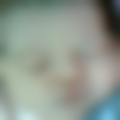

In [14]:
blurred_image

In [15]:
input_tensor.shape

torch.Size([1, 3, 120, 120])

In [16]:
attributions.shape

torch.Size([1, 3, 120, 120])

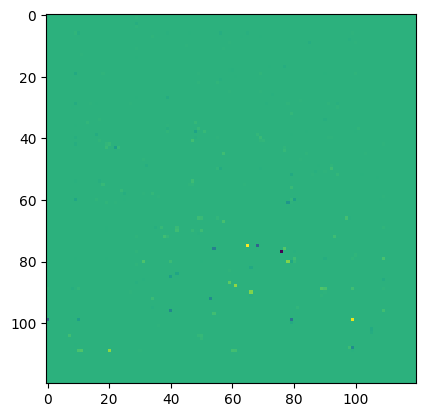

In [17]:
plt.imshow(attributions_normalized)

In [9]:
data = np.load(output_path)['mask']

In [10]:
data.min(), data.max() 

(-1.0, 0.69815975)

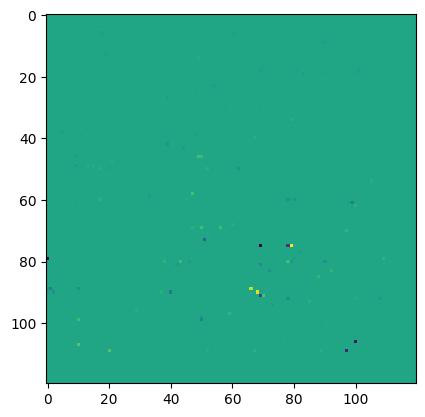

In [11]:
plt.imshow(data)

In [ ]:
dataframe = pd.read_csv(os.path.join("RGU", f'{XAI_name}.csv'))

In [ ]:
dataframe

,img_path,fold,label,prediction,probability,sensitivity,infidelity,mask_path
0,Datasets\Folds\0\Test\ID167_iCOPE_S15_pain.jpg,0,1,0,0.456509,0.750383,0.102988,RGU\GuidedGradCAM\ID167_iCOPE_S15_pain.npz
1,Datasets\Folds\0\Test\ID168_iCOPE_S15_pain.jpg,0,1,0,0.318261,1.598940,0.344880,RGU\GuidedGradCAM\ID168_iCOPE_S15_pain.npz
2,Datasets\Folds\0\Test\ID169_iCOPE_S15_pain.jpg,0,1,1,0.550553,0.421230,0.344274,RGU\GuidedGradCAM\ID169_iCOPE_S15_pain.npz
3,Datasets\Folds\0\Test\ID170_iCOPE_S15_pain.jpg,0,1,1,0.692392,0.528982,0.514498,RGU\GuidedGradCAM\ID170_iCOPE_S15_pain.npz
4,Datasets\Folds\0\Test\ID171_iCOPE_S15_nopain.jpg,0,0,0,0.292135,104.545883,0.027437,RGU\GuidedGradCAM\ID171_iCOPE_S15_nopain.npz
...,...,...,...,...,...,...,...,...
516,Datasets\Folds\9\Test\ID378_UNIFESP_S35_pain.jpg,9,1,1,0.997696,0.480532,3.969360,RGU\GuidedGradCAM\ID378_UNIFESP_S35_pain.npz
517,Datasets\Folds\9\Test\ID379_UNIFESP_S35_pain.jpg,9,1,1,0.981087,0.491574,3.617390,RGU\GuidedGradCAM\ID379_UNIFESP_S35_pain.npz
518,Datasets\Folds\9\Test\ID380_UNIFESP_S35_pain.jpg,9,1,1,0.953660,0.594893,2.919832,RGU\GuidedGradCAM\ID380_UNIFESP_S35_pain.npz
519,Datasets\Folds\9\Test\ID381_UNIFESP_S35_pain.jpg,9,1,1,0.974381,0.481758,3.755785,RGU\GuidedGradCAM\ID381_UNIFESP_S35_pain.npz


# LIME With Facial Features

In [ ]:
from captum.attr import Lime
from XAI.metrics import  create_face_regions_masks
import pickle
from utils import resize_landmarks
import cv2
import torch
from captum.attr import visualization as viz


In [ ]:
with open(f'Datasets/DatasetFaces/Landmarks/{id}.pkl', 'rb') as f:
    landmarks = pickle.load(f)

test = create_face_regions_masks(landmarks)

test['eyes'] = test['right_eye'] + test['left_eye']
test['eyebrown'] = test['right_eyebrown'] + test['left_eyebrown']
test['nasolabial_fold'] = test['right_nasolabial_fold'] + test['left_nasolabial_fold']
test['cheek'] = test['right_cheek'] + test['left_cheek']

test.pop('right_eye')
test.pop('left_eye')
test.pop('right_eyebrown')
test.pop('left_eyebrown')
test.pop('right_nasolabial_fold')
test.pop('left_nasolabial_fold')
test.pop('right_cheek')
test.pop('left_cheek')
test.pop('outside')

features = np.zeros((img_size,img_size))

for i,mask in enumerate(test):
    features[np.where(cv2.resize(test[mask], (img_size,img_size), interpolation=cv2.INTER_NEAREST) == 1)] = i

features = np.stack([features] * 3, axis=0)

In [ ]:
from captum.attr._core.lime import get_exp_kernel_similarity_function
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso


In [ ]:
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)

def iter_combinations(*args, **kwargs):
    for i in range(2 **  len(test)):
        yield torch.tensor([int(d) for d in bin(i)[2:].zfill( len(test))]).unsqueeze(0)


lr_lime = Lime(
    model, 
    interpretable_model=SkLearnLasso(alpha=0.08),  # build-in wrapped sklearn Linear Regression
    similarity_func=exp_eucl_distance,
    perturb_func=iter_combinations
)


attrs = lr_lime.attribute(
    img_transformed,
    feature_mask=torch.tensor(features, dtype=torch.int64),
    n_samples=2 ** len(test),
    perturbations_per_eval=16,
    show_progress=True
).squeeze(0)

In [ ]:
def show_attr(attr_map):
    viz.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),  # adjust shape to height, width, channels 
        method='heat_map',
        sign='all',
        show_colorbar=True
    )
    
show_attr(attrs.cpu().detach())

# RISE

In [ ]:
from XAI import RISE
from models import NCNN, VGGFace
import torch
from dataloaders import presets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = "cuda"

In [ ]:
rise = RISE(model, input_size=(224,224), gpu_batch=10, device=device)

rise.generate_masks(1000, 8, 0.1)

In [ ]:
plt.imshow(rise.masks[0].cpu()[0])

In [ ]:
model.predict(img_transformed.unsqueeze(0).to(device))

In [ ]:
plt.imshow(mask.cpu())
plt.imshow(img.resize((224,224)), alpha=0.5)